In [3]:
from math import pi, sqrt, cosh, exp, floor, tanh, log, sinh, cosh
import numpy as np
from numpy import linspace, logspace
from scipy.optimize import fsolve
from scipy.integrate import quad

import matplotlib.pyplot as plt
#makes plots bigger and use Latex fonts
from matplotlib import rcParams
rcParams["figure.dpi"]=600
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2.5

In [4]:
HBARC = 197.3269718
NEUTRON_MASS = 939.5653 / HBARC
PROTON_MASS = 938.272 / HBARC
NUCLEON_MASS = 2 * NEUTRON_MASS * PROTON_MASS / (NEUTRON_MASS + PROTON_MASS)
MUON_MASS = 105.7 / HBARC
ELECTRON_MASS = 0.511 / HBARC
GA = 1.267
MEVFM3_TO_GCM3 = 1.78e12
FM4_TO_DYNECM2 = 3.16e35
G_TO_FM = 7.69**2 / 10**16 / HBARC**2

COS_TC = sqrt(0.95)
GF = (HBARC / 292800)**2
GN = -1.913 * 2
GP = 3.586 + 2

def gntilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GN * eb / (4 * NUCLEON_MASS * t)))
def gptilde(eb, t):
    return GF**2 * COS_TC**2 * eb / (4 * pi * cosh(GP * eb / (4 * NUCLEON_MASS * t)))

def fermi_dirac(x):
    x = np.asarray(x)  # Ensure input is an array if it's not already
    result = np.empty_like(x, dtype=np.float64)
    
    # For x > 0, use the identity: 1 / (exp(x) + 1) = exp(-x) / (1 + exp(-x))
    pos_mask = x > 0
    result[pos_mask] = np.exp(-x[pos_mask]) / (1 + np.exp(-x[pos_mask]))
    
    # For x <= 0, compute directly: 1 / (exp(x) + 1)
    result[~pos_mask] = 1 / (np.exp(x[~pos_mask]) + 1)
    
    return result

def nfd(e, mu, t):
    return fermi_dirac((e - mu) / t)
    #if (e - mu) / t > 20:
    #    return 0
    #elif (e - mu) / t < -20:
    #    return 1
    #return 1 / (np.exp((e - mu) / t) + 1)

In [5]:
def electron_energy(eb, n, kz):
    return np.sqrt(2 * n * eb + kz**2 + ELECTRON_MASS**2)

def log_electron_density(mu, eb, t):
    if mu < 0:
        max_ll = 2 * floor(t**2 / (2 * eb))
    else:
        max_ll = 2 * floor((t + mu)**2 / (2 * eb))

    pos_ll = linspace(1, max_ll, max_ll)
    return log(quad(lambda kz: eb / (2 * pi**2) * (nfd(np.sqrt(kz**2 + ELECTRON_MASS**2), mu, t) + 2 * np.sum(nfd(electron_energy(eb, pos_ll, kz), mu, t))), 0, max((20 * t, 20 * (t + mu), 50 * sqrt(t * 2 * eb))))[0])

def mue_solver(ne, eb, t):
    return fsolve(lambda mu: log(ne) - log_electron_density(mu, eb, t), 5 / HBARC)[0]

In [6]:
#if ne is 0, set ne0 to 1
def mat_elt(sp, sn, ct_nu, ne0 = 0):
    if sp == 1 and sn == 1:
        return 2 * (1 + GA)**2 * (1 + ct_nu) + 2 * (1 - GA)**2 * (1 - ct_nu) * (1 - ne0)
    elif sp == 1 and sn == -1:
        return 8 * GA**2 * (1 - ct_nu)
    elif sp == -1 and sn == 1:
        return 8 * GA**2 * (1 + ct_nu) * (1 - ne0)
    elif sp == -1 and sn == -1:
        return 2 * (1 - GA)**2 * (1 + ct_nu) + 2 * (1 + GA)**2 * (1 - ct_nu) * (1 - ne0)
    else:
        print('invalid spin')
        return 0

In [19]:
def nun_opacity_high(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + (GP - 2) * sp * eb / (4 * NUCLEON_MASS)
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, 1) * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp(GP * sp * ebmt / 2) * exp(-ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) * 2 / (ebmt + 1 - exp(-ebmt))
                * exp(- knu**2 * (1 - ct_nu**2) / (2 * eb + 2 * mt) * eb * exp(-ebmt) / (eb + mt * (1 - exp(-ebmt))) - knu**2 * ct_nu**2 / (4 * mt)))
    return result

def nun_opacity_med(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            v_tilde = max((e0pl**2 / eb, 1))
            if v_tilde == 1:
                ne0 = 1
            else:
                ne0 = 0
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, ne0) * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) * sinh(ebmt / 2) / cosh(GP * ebmt / 4) / ebmt * exp(- knu**2 / (4 * mt)))
    return result

def nun_opacity_low(nb, yp, eb, t, knu, ct_nu):
    mt = NUCLEON_MASS * t 
    ebmt = eb / mt
    neut_density = nb * (1 - yp)
    prot_density = nb * yp
    mue = mue_solver(prot_density, eb, t)
    #print(mue, prot_density, exp(log_electron_density(mue, eb, t)))

    result = 0
    for sp in (-1, 1):
        for sn in (-1, 1):
            e0pl = knu + NEUTRON_MASS - PROTON_MASS - GN * sn * eb / (4 * NUCLEON_MASS) + GP * sp * eb / (4 * NUCLEON_MASS)
            v_tilde = e0pl**2 / eb
            if v_tilde == 1:
                ne0 = 1
            else:
                ne0 = 0
            result += gntilde(eb, t) * neut_density / 2 * mat_elt(sp, sn, ct_nu, ne0) * (1 - nfd(e0pl, mue, t)) * exp(GN * sn * ebmt / 2) * (
                1 - prot_density / 2 * exp(GP * sp * ebmt / 2) * (pi / mt)**(3 / 2) / cosh(GP * ebmt / 4) * exp(- knu**2 / (4 * mt)))
    return result

In [203]:
nun_opacity_high(0.00016, 0.25, 10**17 * G_TO_FM, 1 / HBARC, 10 / HBARC, 0) * 10**13

3.671899059497774e-06

In [204]:
nun_opacity_med(0.00016, 0.25, 10**17 * G_TO_FM, 1 / HBARC, 10 / HBARC, 0) * 10**13

3.863293956972638e-06

In [164]:
2.5 * 10**-41 * 10**39 * 0.9 * 0.16 * 10**-3

3.6e-06

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


(1e-06, 0.0001)

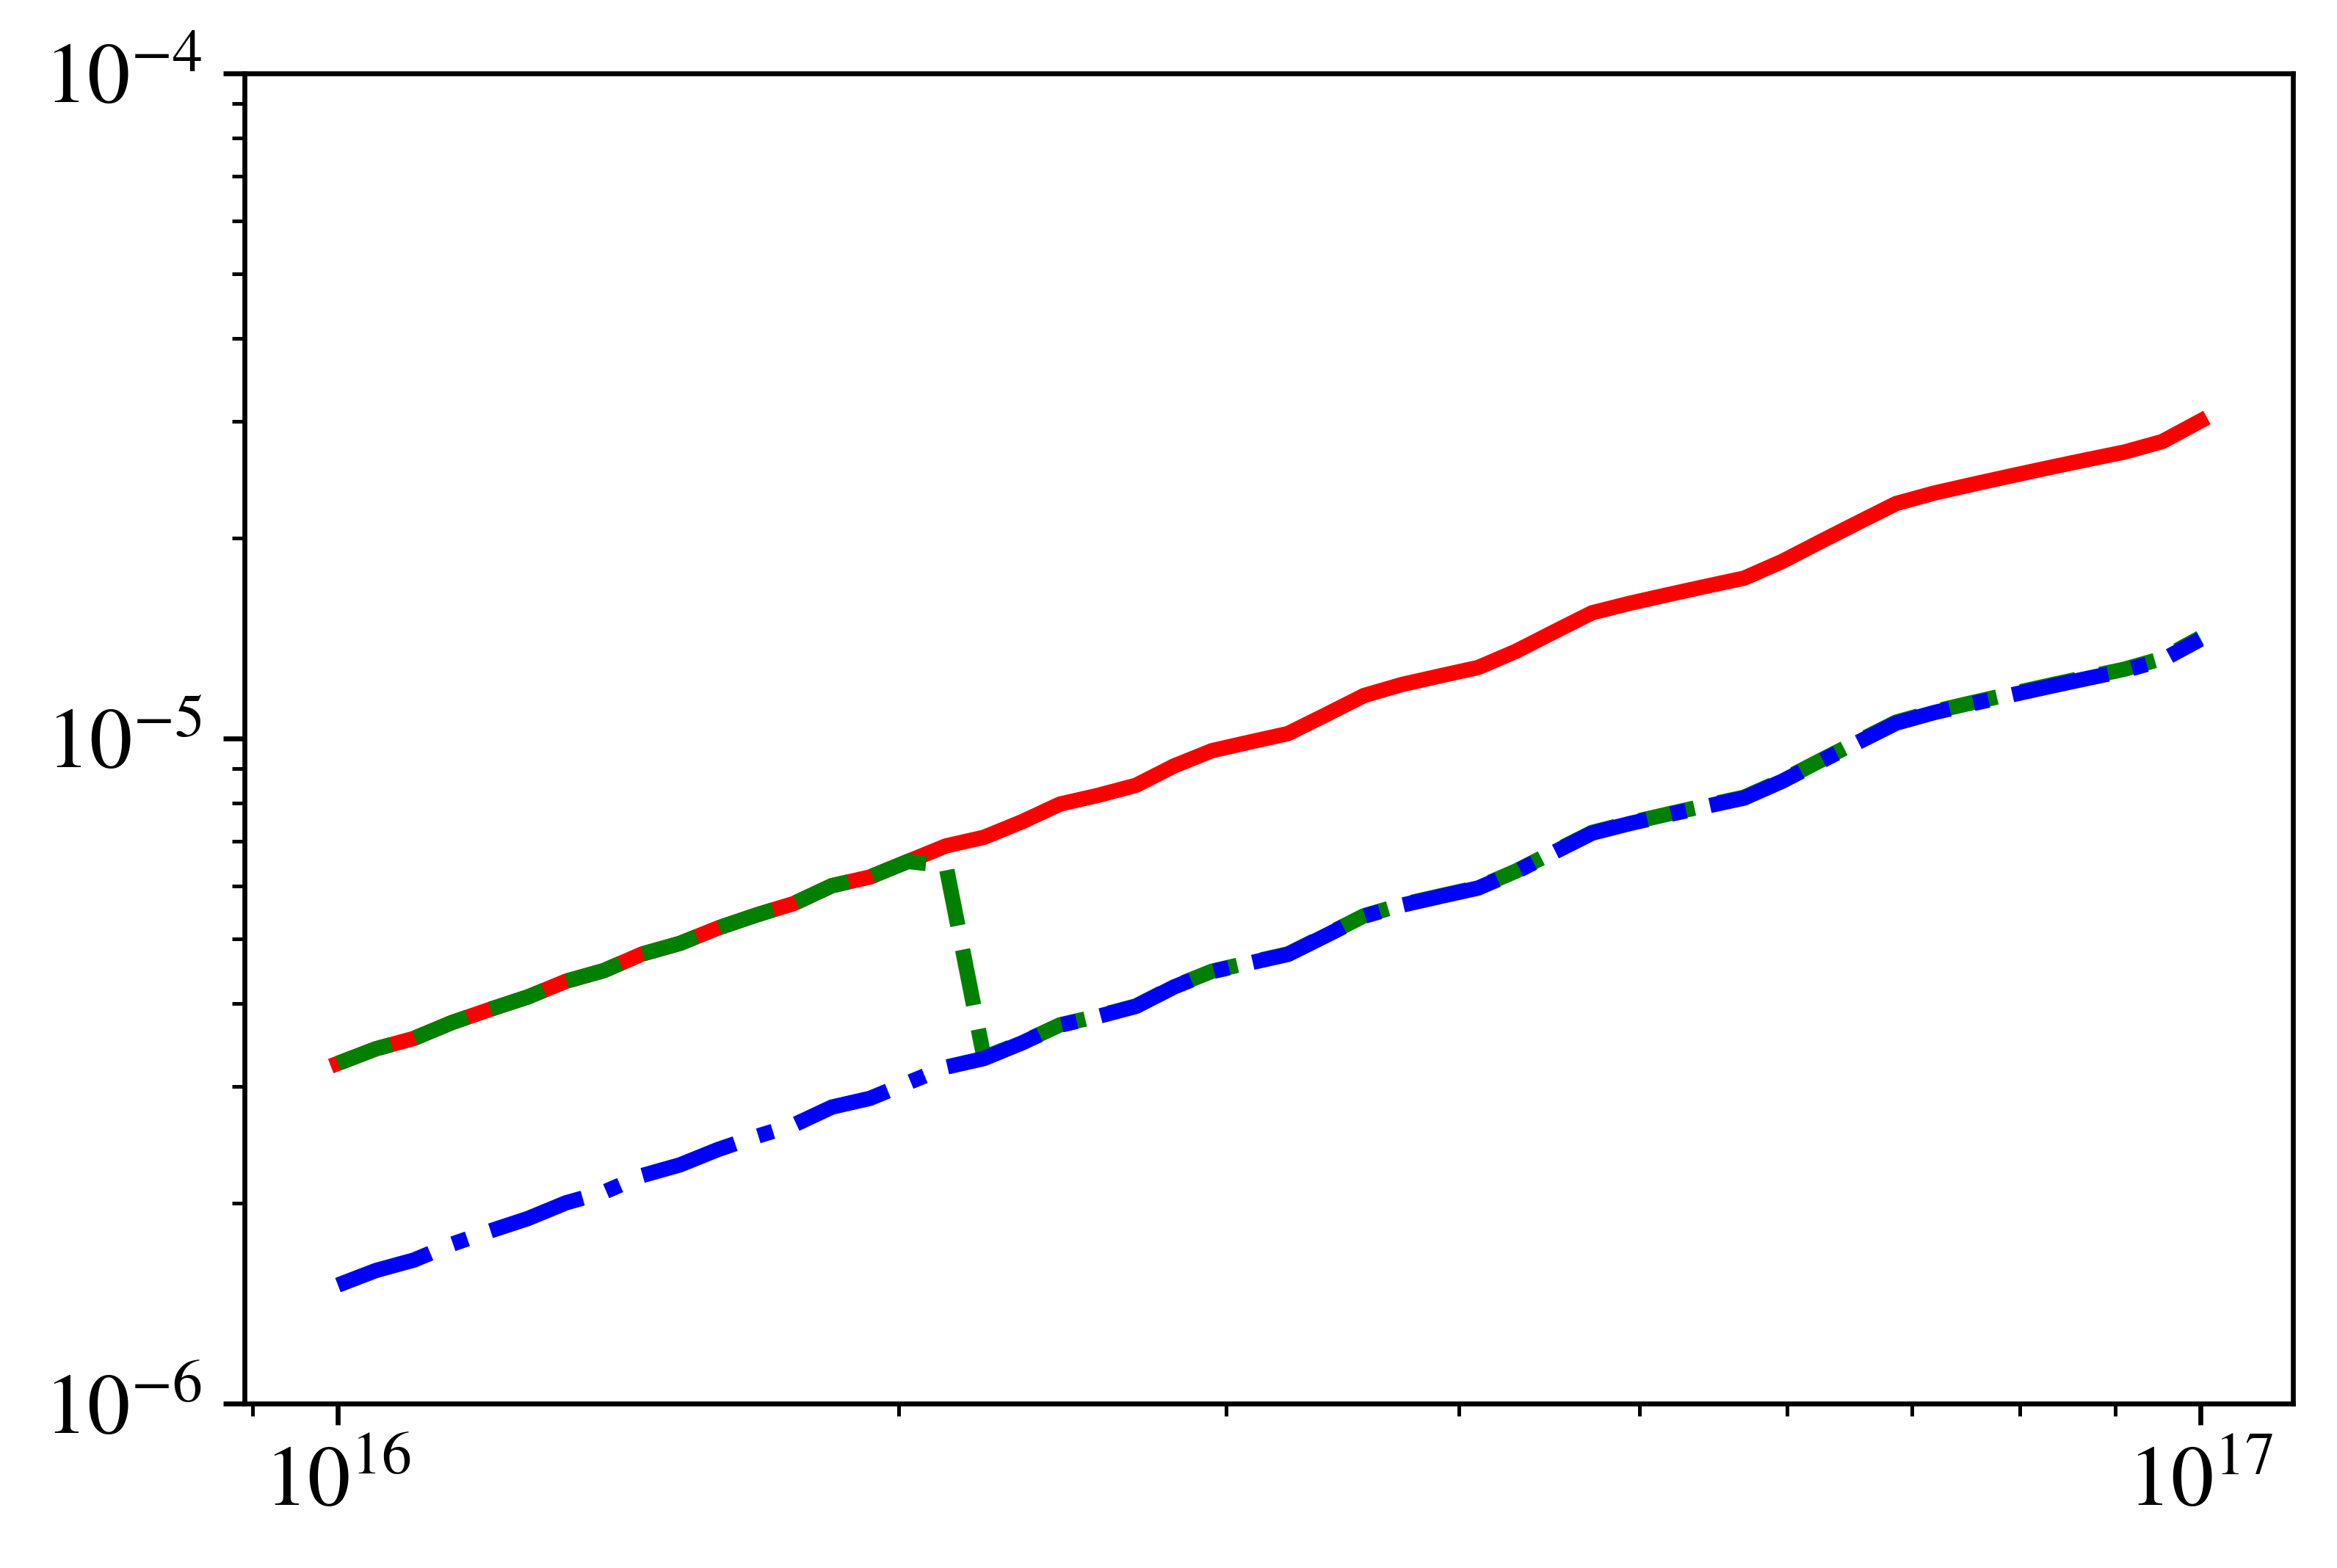

In [20]:
bspace = logspace(16, 17, 50)

plt.plot(bspace, [nun_opacity_low(0.16 * 10**-2, 0.25, b * G_TO_FM, 30 / HBARC, 10 / HBARC, 0.7) * 10**13 for b in bspace], 'r-',
         bspace, [nun_opacity_med(0.16 * 10**-2, 0.25, b * G_TO_FM, 30 / HBARC, 10 / HBARC, 0.7) * 10**13 for b in bspace], 'g--',
         bspace, [nun_opacity_high(0.16 * 10**-2, 0.25, b * G_TO_FM, 30 / HBARC, 10 / HBARC, 0.7) * 10**13 for b in bspace], 'b-.')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-6, 1e-4])